## Measuring cache size dependence in the memory latency of ec2 instances
>Team 4 - HW2 - DSC 291 - April 20, 2020 - Univ. of Calif. SD

- **nota bene**: miss_fraction can be estimated visually from our log-log plots by looking for the y-value (1-CDF) where the data's curve crosses with the dotted normal curve
- TODO: estimate miss_fraction for t3.small for each block size. record.
- TODO: estimate miss_fraction for t3a.small for each block size. record.


- TODO: repeat ^those for several trials
- TODO: test if the mean miss_fraction is different for the two groups using scipy.stats.ttest_ind(values_1,values_2)

In this notebook, you will overcome a problem with the `time()` function, which is only accurate up to $10^{-7}$ seconds. We perform many random pokes in sequence and measure the time it takes to complete all of the pokes.

As we are interested in times shorter than $10^{-7}$ we restrict our attention to the main memory, rather than to files.

In [1]:
%pylab inline
#initialize namespaces
import os, sys, shutil, time
import pandas as pd, scipy.stats as stats
from numpy import *
from matplotlib.backends.backend_pdf import PdfPages
from os.path import isfile,isdir
from os import mkdir
from lib.measureRandomAccess import measureRandomAccess
from measureRandomAccessMemBlocks import *
from lib.PlotTime import PlotTime
from IPython.display import Image
if 'nb_dir' not in globals():
    nb_dir = os.getcwd()

Populating the interactive namespace from numpy and matplotlib


## Question: 

>How does the performance of random-poke.py relate to the size of the L3 cache in the ec2 instance?


### Abstract
We control for instance features by looking for differences two similar yet distinct ec2 instance types: t3.small and t3a.small.  These two instance types are very similar, with the exeption of ??. We performed the following analysis at several times of day both on a weekday and on a weekend to arrive at consistent [significant?] results ($p = ??$).

### Key Results
* Measurements are self-consistent at time scales of minutes [& hours]
* Most reads L1 and L2 memory are nearly instantaneous cache hits, $10^{-8}$ seconds
* ??±?? % is the liklihood that a cache miss will occur under [conditions1??] holding [conditions2??] fixed.

## Description of the fields

__**Explanatory Variables/Inputs**__
* **datetime** the time and date
* **type** the type of instance
* **k** number of pokes per location poked
* **batch** the number of locations poked in a single trial experiment (multiple pokes performed using numpy, rather than python loop)

__**Dependent Variables/Outputs**__
* **_mean** mean latency of trial in seconds
* **_std** mean latency of trial in seconds
* **T** list the latency times
* **miss_fraction** number of cache misses / total number of trials

## Description of Experiment:

__*In brief,*__
 - a trial contains at least one cache miss if the mean latency is significantly smaller than the sample standard deviation
 - the fraction of cache misses is estimated from the fraction of outlier latencies
 - the fraction of cache misses is studied by systematically varying one explanatory variable at a time
 
__*setting parameters*__
* We test access to elements arrays whose sizes are:
   * 1MB, 10MB, 100MB, 1000MB (=1GB)
* Arrays are stored on an ec2 instance in L1, L2, or L3 caches of known size

We will be measuring performance of the t3.small and t3a.small EC2 instances in terms of their latency when performing random-poke.py with varying block sizes.  In particular, t3.small has an L3 cache size of 33MB and t3a.small has an L3 cache size of 64MB. To keep other variables constant as much as possible, these EC2 instances were chosen because they each have 2 cores and 2 GiB of memory. 

Our experiment will consist of choosing a single hour during a high load time and a single hour during a low load time to run random-poke.py with varying block sizes each 1,000 times on both a t3.small EC2 instance and a t3a.small EC2 instance. The block sizes will range from size 10MB to 70MB, and will increase by 10MB at each step. We will compute the mean and standard deviations of the latency times for each instance on the varying block sizes, once per minute, over the course of an hour. We will then compare the means and standard deviations of the latency times between the two EC2 instances in order to see how the performance of random-poke.py differs on these instances of differing L3 cache sizes.

We will use the Kolmagorov-Smirnov test, a statistical p-test, to test the following hypotheses: 

Null Hypothesis: L3 cache sizes have no effect on the performance of ec2 clusters for block sizes = 10, 20, 30, 40, 60. 
Alternate Hypothesis: Higher cache size leads to lower latency times (better performance) depending on the block size.
Qualitative Hypothesis: We expect t3.small and t3a.small to perform similarly when the given block size fits within both of their caches. Since t3a.small has a larger cache size than t3.small, on block sizes which are larger than the L3 cache of t3.small but smaller than the L3 cache of t3a.small, we expect t3a.small to outperform t3.small.  
Hypothesis Testing: In particular, a p-test will be done separately for each block size. We will report the block sizes which have significant differences in their latency times, and conclude with how EC2 instances' performance relates to the L3 cache size.




### setting parameters
* We test access to elements arrays whose sizes are:
   * 1MB, 10MB, 100MB, 1000MB (=1GB)
* Arrays are stored **in memory** or on disk **on disk**

* We perform 1 million read/write ops  to random locations in the array.
* We analyze the **distribution** of the latencies.

In [2]:
n=100 # size of single block (1MB)
m_list=[1,10,100,1000,10000] # size of file in blocks
k=100000;  # number of repeats
L=len(m_list)
print('n=%d, k=%d, m_list='%(n,k),m_list)

n=100, k=100000, m_list= [1, 10, 100, 1000, 10000]


### Set working directory
This script generates large files. We put these files in a separate directory so it is easier to delete them later.

In [12]:
log_root='./logs'
if not isdir(log_root): mkdir(log_root)
TimeStamp=str(int(time.time()))
log_dir=log_root+'/'+TimeStamp
mkdir(log_dir)
%cd $log_dir
stat=open('stats.txt','w')

def tee(line):
    print(line)
    stat.write(line+'\n')

/Users/timothytyree/Documents/GitHub/dsc291team4/HW2/data/Performance_logs/m5ad.2xlarge_performance/logs/1587366447


In [13]:
_mean=zeros([2,L])   #0: using disk, 1: using memory
_std=zeros([2,L])
Tmem=[]; TFile=[]
m_list=[10000000, 20000000, 30000000, 40000000, 50000000, 60000000, 70000000]
m_legend=['10MB', '20MB', '30MB', '40MB', '50MB', '60MB', '70MB']

In [18]:
import datetime
now = datetime.datetime.now()
# print(now)
!Pwd

/Users/timothytyree/Documents/GitHub/dsc291team4/HW2/python


In [ ]:
os.chdir(nb_dir)
%run aws-jupyter-scripts/run_trial.py

In [22]:
#create and store the results. 
#loop for the code below to run a trial of random_pokes() once per minute.
num_trials = 0
while num_trials < 12:   # number of trials to run of time length x in time.sleep(x)
    now = datetime.datetime.now()
    print(f"trial completed at {str(now)}")
    %run aws-jupyter-scripts/run_trial.py
    sleep(60*10)
    num_trials += 1


trial completed at 2020-04-20 00:18:31.361361
 99900 

NameError: name 'sleep' is not defined

## Results

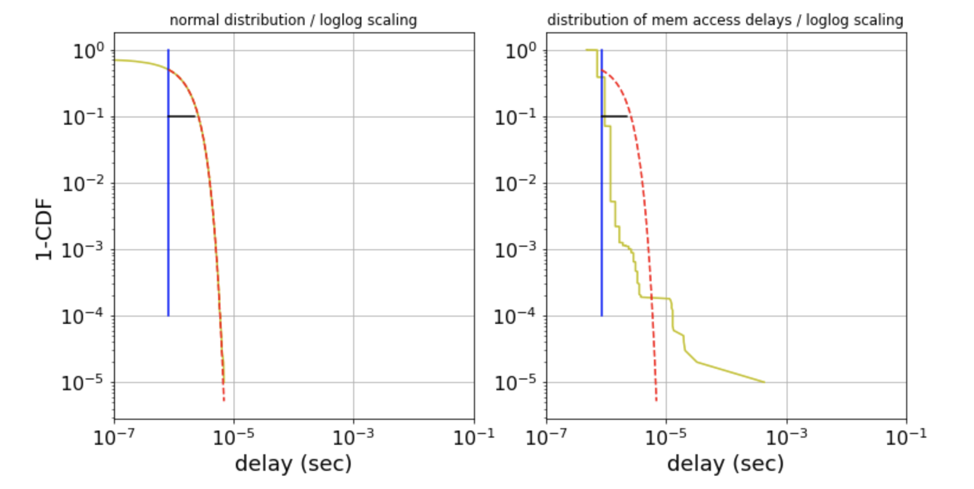

In [5]:
img_fn = f'{nb_dir}/../fig/fig_a.png'
assert(os.path.exists(img_fn))
Image(filename=img_fn, width = 600)

Plotted is unity minus the cummulative distribution function (CDF) for the normal distribution (left) and for cache hits/misses (right).    The crossing of the dotted line and the solid line indicate that 

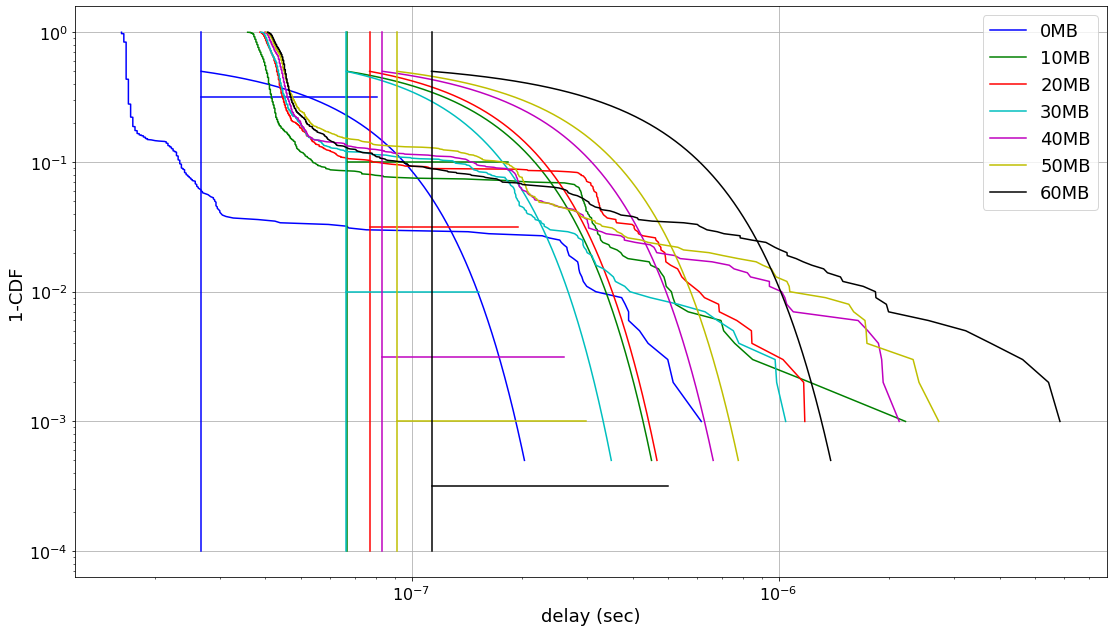

In [6]:
img_fn = f'{nb_dir}/../fig/fig_survival_plot.png'
assert(os.path.exists(img_fn))
Image(filename=img_fn, width = 600)

We see that for this ec2 instance (t3.small?), roughly $90\%$ of latency times are smaller than $10^{-8}$ seconds for 
for blocks of size up to 50 MB. Beyond that, for sizes of 60MB, roughly $3\%$ of latency times are smaller than $10^{-8]$ seconds.

This makes sense because the size of the L2 cache in this ec2 instance is full at about ?? MB.

# statistical tests

In [7]:
#import saved results
import pickle as pk
pkl_dir = f"{nb_dir}/../data/Performance_Logs/m5ad.2xlarge_performance/"
os.chdir(pkl_dir)
pkl_fn = "worker-0/multi_processing_stats.pkl"
with open(pkl_fn,'rb') as pkl:
    stat=pk.load(pkl)

In [8]:
# 	stat.keys()
# 	print(stat['creation_stats'])
# 	print(f"Output has {len(stat['Random_pokes'])} measurements.")
# 	for pkl in stat['Random_pokes']:
# 	    print(f"input size = {pkl['m']:.1e}.")
# 	    print(f"mean latency (sec) = {pkl['memory__mean']:.3e}.")
# 	    print(f"std latency (sec) = {pkl['memory__std']:.3e}.")
# 	    print(f"mean of largest 100 latencies (sec) = {np.mean(pkl['memory__largest']):.3e}.")
# 	    print('')

In [9]:
### Statistical Test
values_1 = [1,2,3]#"TODO"#list of VALUES for t3.small
values_2 = [1,2,3]#"TODO"#list of VALUES for t3a.small
from scipy.stats import ttest_ind
retval = ttest_ind(values_1,values_2)
print(retval)
# I reccomend using VALUES = miss_fraction = number of cache misses / total number of trials


Ttest_indResult(statistic=0.0, pvalue=1.0)


## Discussion
 

## Conclusion

# Acknowledgments

# Hours
###On Tuesday, tell me how much time you spent on HW2 
###Purisa Jasmine Simmons, Timothy Tyree, Ria Agarwal, Ayon
###Professor Yoav Freund 
###DSC 291 
###Due: Tues. April 21, 2020